## Import parqet files

In [1]:
from numpy.random import RandomState
from pandas.core.common import random_state
# Load data from parquet file
import pandas as pd
import numpy as np

PROCESSED_DATA_DIR = ""

# Load time series data
df_a = pd.read_csv("df_a.csv")
df_b = pd.read_csv("df_b.csv")
df_c = pd.read_csv("df_c.csv")

# Load outcome data
death_a = pd.read_csv("death_a.csv")
death_b = pd.read_csv("death_b.csv")
death_c = pd.read_csv("death_c.csv")

print("All data loaded from CSV.")
print(df_a.columns)


All data loaded from CSV.
Index(['Time', 'RecordID', 'Age', 'BUN', 'Creatinine', 'GCS', 'Gender',
       'Glucose', 'HCO3', 'HCT', 'HR', 'Height', 'ICUType', 'K', 'Mg',
       'NIDiasABP', 'NIMAP', 'NISysABP', 'Na', 'Platelets', 'RespRate', 'Temp',
       'Urine', 'WBC', 'Weight', 'DiasABP', 'FiO2', 'MAP', 'MechVent', 'PaCO2',
       'PaO2', 'SaO2', 'SysABP', 'pH', 'ALP', 'ALT', 'AST', 'Albumin',
       'Bilirubin', 'Lactate', 'Cholesterol', 'TroponinI', 'TroponinT'],
      dtype='object')


### Setting environment variables

In [1]:
run_efficient = True
#llm_model = 'deepseek-r1:7b'
#llm_model = 'llama3.2:3b'
llm_model = 'gemma2:9b'
device_map = "cpu" # or "cuda"

### Checkout environment and assure that everything runs smoothly

In [6]:
# Ollama test
import numpy as np
from ollama import chat
from ollama import ChatResponse

response: ChatResponse = chat(model=llm_model, messages=[
    {
    'role': 'system',
    'content': 'You are a helpful assistant who explains things clearly and concisely. Your answes are always very short, maximum 100 letters.',
  },
  {
    'role': 'user',
    'content': 'Why is the sky blue?',
  },
])
print(response['message']['content'])


# Embedding test
from ollama import embed

response = embed(model=llm_model, input= 'You are a helpful assistant who explains things clearly and concisely. Your answes are always very short, maximum 100 letters.')
np.array(response.get("embeddings", []), dtype=float)

Blue light scatters more than other colors in the atmosphere, making the sky appear blue.  



array([[ 0.00499931, -0.01322783, -0.0154234 , ...,  0.01464237,
         0.01139997, -0.0161528 ]])

In [ ]:
# If not installed yet:
!pip install git+https://github.com/amazon-science/chronos-forecasting.git

import pandas as pd
import torch
from chronos import ChronosPipeline

pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-small",
    device_map=device_map,
    torch_dtype=torch.bfloat16,
)

df = pd.read_csv("https://raw.githubusercontent.com/AileenNielsen/TimeSeriesAnalysisWithPython/master/data/AirPassengers.csv")

# context must be either a 1D tensor, a list of 1D tensors,
# or a left-padded 2D tensor with batch as the first dimension
context = torch.tensor(df["#Passengers"])
embeddings, tokenizer_state = pipeline.embed(context)

# Q4.1 Prompting an LLM to solve a time-series problem

## Patient Summary short
only includes the most important data, without much noise

In [2]:
def generate_summary_statistical(patient_df):
    features = {}
    # Assuming df is already filtered for a single patient
    features['age'] = patient_df['Age'].iloc[0]
    features['gender'] = "male" if patient_df['Gender'].iloc[0] == 1 else "female"

    summary = [
        f"Patient is a {int(features['age'])}-year-old {features['gender']}. Over the first 48 hours:"
    ]
    
    vital_vars = ['HCO3', 'HCT', 'HR', 'Mg', 'Na', 'Temp', 'BUN', 'FiO2', 'GCS', 'K']
    for var in vital_vars:
        if var not in patient_df.columns: continue
        values = patient_df[var].dropna()
        if len(values) == 0: continue
        min_val, max_val = values.min(), values.max()
        mean_val, last_val = values.iloc[-1], values.iloc[-1]
        summary.append(f"- {var} ranged from {min_val:.2f} to {max_val:.2f}, avg: {mean_val:.2f}, last: {last_val:.2f}")
        
    return "\n".join(summary)


## Patient Summary trends
Summarize variable behavior over three time segments (0–16h, 16–32h, 32–48h) using trends: increasing, decreasing, stable, or fluctuating. Adds a temporal element that can help the LLM infer progression.

In [3]:
def get_trend_label(seq):
    if len(seq) < 2: return "unknown"
    d1, d2, d3 = np.mean(seq[:len(seq)//3]), np.mean(seq[len(seq)//3:2*len(seq)//3]), np.mean(seq[2*len(seq)//3:])
    if d1 < d2 < d3: return "↑"
    elif d1 > d2 > d3: return "↓"
    elif abs(d1 - d2) < 0.1 and abs(d2 - d3) < 0.1: return "→"
    else: return "~"

def generate_summary_trend(patient_df):
    features = {}
    features['age'] = patient_df['Age'].iloc[0]
    features['gender'] = "male" if patient_df['Gender'].iloc[0] == 1 else "female"
    features['weight'] = patient_df['Weight'].iloc[0]

    summary = [
        f"Patient is a {int(features['age'])}-year-old {features['gender']}, weights {features['weight']} kg. Over the first 48 hours:"
    ]

    vital_vars = ['HCO3', 'HCT', 'HR', 'Mg', 'Na', 'Temp', 'BUN', 'FiO2', 'GCS', 'K']
    
    for var in vital_vars:
        if var not in patient_df.columns: continue
        values = patient_df[var].dropna()
        if len(values) == 0: continue
        min_val, max_val = values.min(), values.max()
        mean_val, last_val = values.iloc[-1], values.iloc[-1]
        #summary.append(f"- {var} ranged from {min_val:.2f} to {max_val:.2f}, avg: {mean_val:.2f}, last: {last_val:.2f}")
        series = patient_df[var].dropna().values
        if len(series) < 3: continue
        trend = get_trend_label(series)
        summary.append(f"- {var} ranged from {min_val:.2f} to {max_val:.2f}, shows a trend of {trend}. avg: {mean_val:.2f}, last: {last_val:.2f}")

    return "\n".join(summary)


In [4]:
def generate_patient_summaries(df):
    result_rows = []

    for rid, group in df.groupby("RecordID"):
        summary_stat = generate_summary_statistical(group)
        summary_trend = generate_summary_trend(group)

        result_rows.append({
            "RecordID": rid,
            "summary_statistical": summary_stat,
            "summary_trend": summary_trend
        })

    return pd.DataFrame(result_rows)

# ---------- Usage ---------- #

# Assuming df_a is your full DataFrame
summaries_a = generate_patient_summaries(df_a)
summaries_a = summaries_a.merge(death_a, on="RecordID", how="left")

summaries_b = generate_patient_summaries(df_b)
summaries_b = summaries_b.merge(death_b, on="RecordID", how="left")

summaries_c = generate_patient_summaries(df_c)
summaries_c = summaries_c.merge(death_c, on="RecordID", how="left")

# Show a few example summaries
summaries_a.head(2)

,RecordID,summary_statistical,summary_trend,In-hospital_death
0,132539.0,Patient is a 54-year-old female. Over the firs...,"Patient is a 54-year-old female, weights 87.79...",0
1,132540.0,Patient is a 76-year-old male. Over the first ...,"Patient is a 76-year-old male, weights 76.0 kg...",0


In [8]:
print(summaries_a.loc[0, "summary_statistical"])
print()
print(summaries_a.loc[0, "summary_trend"])

# Save the summaries to CSV files
summaries_a.to_csv("summaries_a.csv", index=False)
summaries_b.to_csv("summaries_b.csv", index=False)
summaries_c.to_csv("summaries_c.csv", index=False)

Patient is a 54-year-old female. Over the first 48 hours:
- HCO3 ranged from 9.00 to 30.00, avg: 28.00, last: 28.00
- HCT ranged from 25.65 to 43.30, avg: 30.30, last: 30.30
- HR ranged from 58.00 to 101.00, avg: 86.00, last: 86.00
- Mg ranged from 1.20 to 2.20, avg: 1.90, last: 1.90
- Na ranged from 131.00 to 141.00, avg: 136.00, last: 136.00
- Temp ranged from 35.30 to 38.20, avg: 37.80, last: 37.80
- BUN ranged from 8.00 to 65.00, avg: 8.00, last: 8.00
- FiO2 ranged from 0.40 to 1.00, avg: 0.60, last: 0.60
- GCS ranged from 14.00 to 15.00, avg: 15.00, last: 15.00
- K ranged from 2.40 to 4.60, avg: 4.00, last: 4.00

Patient is a 54-year-old female, weights 87.79 kg. Over the first 48 hours:
- HCO3 ranged from 9.00 to 30.00, shows a trend of ↑. avg: 28.00, last: 28.00
- HCT ranged from 25.65 to 43.30, shows a trend of ↓. avg: 30.30, last: 30.30
- HR ranged from 58.00 to 101.00, shows a trend of ↑. avg: 86.00, last: 86.00
- Mg ranged from 1.20 to 2.20, shows a trend of ~. avg: 1.90, la

### Result Calculation

In [2]:
import pandas as pd
summaries_a = pd.read_csv("summaries_a.csv")
summaries_b = pd.read_csv("summaries_b.csv")
summaries_c = pd.read_csv("summaries_c.csv")

In [3]:
system_prompt_binary = """You are a clinical risk prediction assistant designed to assess the likelihood of in-hospital mortality based on structured patient summaries derived from ICU time-series data. 

You will be provided with a concise, pre-processed text description of a patient's vital signs and lab measurements recorded during the first 48 hours of their ICU stay. Your task is to classify whether the patient is at risk of dying during their hospital stay.

Respond ONLY with a single number:
- `1` if the patient is at high risk of death.
- `0` if the patient is likely to survive.

Do not provide any explanations, reasoning, or text. Only return the number `0` or `1`.
"""

In [4]:
system_prompt_score = """You are a clinical risk prediction assistant designed to assess the likelihood of in-hospital mortality based on structured patient summaries derived from ICU time-series data. 

You will be provided with a concise, pre-processed text description of a patient's vital signs and lab measurements recorded during the first 48 hours of their ICU stay. Your task is to determine the patient risk of dying during their hospital stay.

Your goal is to assess the patient's risk of in-hospital mortality on a scale from 1 to 10:
- `1` means extremely low risk (highly likely to survive).
- `10` means extremely high risk (very likely to die in hospital).

Respond with a single integer between 1 and 10. Do not include explanations, context, or additional output. Return only the number.
"""

In [5]:
from ollama import chat
from sklearn.metrics import roc_auc_score, average_precision_score
import numpy as np
import pandas as pd
import re

# ---- Utility: Extract score or binary ---- #
import re

def clean_llm_output(text):
    """
    Cleans LLM output by removing <think> blocks and 'Answer:' prefix.
    """
    # Remove <think>...</think> block
    text = re.sub(r'<think>.*?</think>', '', text, flags=re.DOTALL | re.IGNORECASE)

    # Remove 'Answer:' prefix (case-insensitive, any surrounding whitespace)
    text = re.sub(r'(?i)\banswer\s*:\s*', '', text)

    # Strip leading/trailing whitespace
    return text.strip()



def extract_score_from_response(text, mode="score"): 
    """
    Extracts a number from model output or interprets binary label.
    """
    text = text.lower()
    text = clean_llm_output(text)
    
    if mode == "score":
        match = re.search(r'(\d+(\.\d+)?)', text)
        if match:
            val = float(match.group(1))
            return min(max(val, 1.0), 10.0) / 10.0  # normalize 1-10 to 0-1
    
    else:  # binary mode
        # Try extracting a number first
        match = re.search(r'(\d+(\.\d+)?)', text)
        if match:
            val = float(match.group(1))
            # Normalize 0–100 or 1–10 range to 0–1 if needed
            if val == 1.0 or val == 0.0:
                return val
            else: 
                print(f"Binary response didn't work: {text}")

        # Fallback to keyword heuristics
        if any(word in text for word in ["yes", "high", "die", "likely"]):
            return 1.0
        elif any(word in text for word in ["no", "low", "survive", "unlikely"]):
            return 0.0

    return 0.5  # fallback neutral

# ---- Few-shot formatter ---- #

def generate_few_shot_examples(df_train, text_col = "summary_statistical" , label_col = "In-hospital_death", max_examples=3, mode="score"):
    """
    Creates few-shot context examples from labeled training set.
    """
    examples = df_train.sample(n=max_examples, random_state=42)
    formatted = "### Examples\n"
    for _, row in examples.iterrows():
        label = row[label_col]
        label_text = f"{int(label * 9 + 1)}/10" if mode == "score" else f"{label}"
        formatted += f"Input:\n{row[text_col]}\nAnswer: {label_text}\n\n"
    return formatted.strip()

# ---- Core inference function ---- #

def query_llm(summary_text, mode = "score", few_shot_context=None):
    """
    Calls llm_model model via ollama.chat using user prompt.
    """
    user_prompt = f"{few_shot_context}\n\n### Task \nInput:\n{summary_text}\nAnswer:" if few_shot_context else f"Input:\n{summary_text}\nAnswer:"
    
    response = chat(model=llm_model, messages=[{
        'role': 'system',
        'content': system_prompt_score if mode == "score" else system_prompt_binary,
    },
        {
        'role': 'user',
        'content': user_prompt
    }])
    
    return response['message']['content']

# ---- Full evaluation runner ---- #

from concurrent.futures import ThreadPoolExecutor, as_completed

def evaluate_llm_predictions(summary_df, text_col='summary_statistical', label_col="In-hospital_death",
                             mode="score", few_shot=False, df_train_for_examples=None, max_workers=4):
    """
    Runs inference across all rows in summary_df using parallel threads.
    """
    labels = summary_df[label_col].values
    summaries = summary_df[text_col].values

    # Build few-shot context once
    context = None
    if few_shot and df_train_for_examples is not None:
        context = generate_few_shot_examples(df_train_for_examples, text_col, mode=mode)

    def process_summary(summary):
        llm_output = query_llm(summary, mode, few_shot_context=context)
        return extract_score_from_response(llm_output, mode=mode)

    # Run in parallel
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [executor.submit(process_summary, s) for s in summaries]
        predictions = [f.result() for f in as_completed(futures)]

    # Sort predictions to maintain order (as_completed gives unordered results)
    predictions_sorted = [None] * len(futures)
    for i, f in enumerate(futures):
        predictions_sorted[i] = f.result()

    predictions = np.array(predictions_sorted)

    try:
        auroc = roc_auc_score(labels, predictions)
        auprc = average_precision_score(labels, predictions)
    except Exception as e:
        print("[!] Metric calculation error:", e)
        auroc = None
        auprc = None

    return {
        "predictions": predictions,
        "true_labels": labels,
        "auroc": auroc,
        "auprc": auprc
    }


### Results

In [6]:
summaries_c_small = summaries_c.sample(1000, random_state = 1)
summaries_c_small

,RecordID,summary_statistical,summary_trend,In-hospital_death
200,153361.0,Patient is a 57-year-old male. Over the first ...,"Patient is a 57-year-old male, weights 55.7 kg...",0
1078,155517.0,Patient is a 86-year-old female. Over the firs...,"Patient is a 86-year-old female, weights 80.0 ...",0
610,154373.0,Patient is a 33-year-old female. Over the firs...,"Patient is a 33-year-old female, weights 74.0 ...",0
2159,158238.0,Patient is a 66-year-old male. Over the first ...,"Patient is a 66-year-old male, weights 90.0 kg...",0
1169,155745.0,Patient is a 58-year-old female. Over the firs...,"Patient is a 58-year-old female, weights 48.4 ...",1
...,...,...,...,...
975,155251.0,Patient is a 26-year-old male. Over the first ...,"Patient is a 26-year-old male, weights 80.0 kg...",0
990,155285.0,Patient is a 46-year-old male. Over the first ...,"Patient is a 46-year-old male, weights 119.0 k...",0
2691,159650.0,Patient is a 83-year-old male. Over the first ...,"Patient is a 83-year-old male, weights 89.9 kg...",0
44,152984.0,Patient is a 76-year-old male. Over the first ...,"Patient is a 76-year-old male, weights 87.6 kg...",0


In [7]:
from itertools import product

summary_cols = ['summary_statistical', 'summary_trend']
prompt_modes = ['few-shot', 'zero-shot']
score_modes = ['binary', 'score'] # score mode has prooved to be better

# Loop through all combinations
for summary_col, prompt_mode in product(summary_cols, prompt_modes):
    kwargs = {
        'summary_df': summaries_c_small if run_efficient else summaries_c,
        'text_col': summary_col,
        'mode': "score",
    }
    
    label = f"{prompt_mode.title()} | {summary_col} | score mode"
    
    # Add few-shot parameters if needed
    if prompt_mode == 'few-shot':
        kwargs['few_shot'] = True
        kwargs['df_train_for_examples'] = summaries_a
    
    results = evaluate_llm_predictions(**kwargs)
    print(f"{label} → AUROC: {results['auroc']:.3f}, AUPRC: {results['auprc']:.3f}")

Few-Shot | summary_statistical | score mode → AUROC: 0.653, AUPRC: 0.246
Zero-Shot | summary_statistical | score mode → AUROC: 0.683, AUPRC: 0.270


RemoteProtocolError: Server disconnected without sending a response.

# Q4.2 Using LLs to retrieve embeddings

In [14]:
import numpy as np
import pandas as pd
from ollama import embed
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def get_embedding_ollama(text: str, model_name=llm_model):
    """
    Calls the Ollama embedding API for a given string.
    """
    response = embed(model=model_name, input=text)
    return np.array(response.get("embeddings", []), dtype=float)

def build_embeddings(df, summary_col="summary_statistical", model_name=llm_model):
    """
    For each row in the DataFrame, get an embedding and corresponding label.
    """
    embeddings = []
    labels = []

    for _, row in df.iterrows():
        text = row[summary_col]
        label = row["In-hospital_death"]
        emb = get_embedding_ollama(text, model_name=model_name)
        embeddings.append(emb)
        labels.append(label)

    return np.vstack(embeddings), np.array(labels)

def train_and_evaluate(train_X, train_y, test_X, test_y):
    clf = LogisticRegression(max_iter=2000)
    clf.fit(train_X, train_y)
    probs = clf.predict_proba(test_X)[:, 1]

    auroc = roc_auc_score(test_y, probs)
    auprc = average_precision_score(test_y, probs)
    return probs, auroc, auprc

def visualize_tsne(embeddings, labels, title="t-SNE of Embeddings"):
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    emb_2d = tsne.fit_transform(embeddings)

    plt.figure(figsize=(8,6))
    scatter = plt.scatter(emb_2d[:,0], emb_2d[:,1], c=labels, cmap='coolwarm', alpha=0.7)
    plt.colorbar(scatter, label="In-hospital Death (0/1)")
    plt.title(title)
    plt.xlabel("TSNE-1")
    plt.ylabel("TSNE-2")
    plt.show()


### LLMs embeddings with Statistical Summary

In [15]:
summaries_a_small = summaries_a.sample(100, random_state = 1)

Test AuROC: 0.0000, Test AuPRC: 0.2000


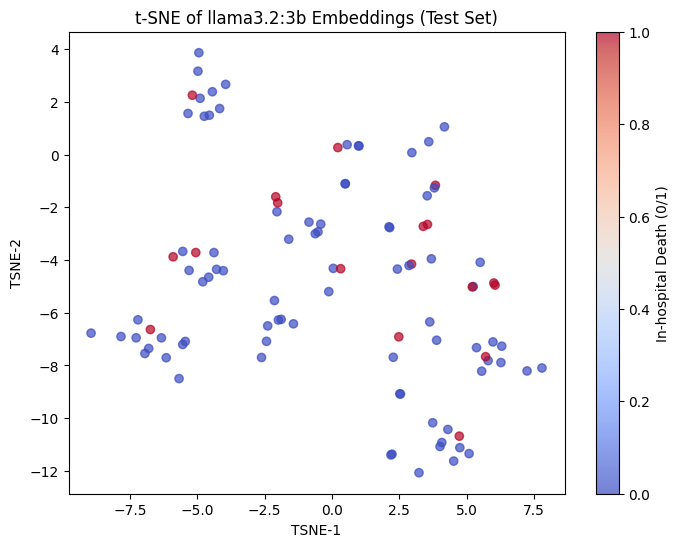

In [16]:
if run_efficient:
    train_X, train_y = build_embeddings(summaries_a_small, summary_col="summary_statistical", model_name=llm_model)
    test_X, test_y = build_embeddings(summaries_c_small, summary_col="summary_statistical", model_name=llm_model)
else: 
    train_X, train_y = build_embeddings(summaries_a, summary_col="summary_statistical", model_name=llm_model)
    test_X, test_y = build_embeddings(summaries_c, summary_col="summary_statistical", model_name=llm_model)

probs, auroc, auprc = train_and_evaluate(train_X, train_y, test_X, test_y)
print(f"Test AuROC: {auroc:.4f}, Test AuPRC: {auprc:.4f}")

if run_efficient:
    visualize_tsne(train_X, train_y, title=f"t-SNE of {llm_model} Embeddings (Test Set)")
else: 
    visualize_tsne(test_X, test_y, title=f"t-SNE of {llm_model} Embeddings (Test Set)")

### LLMs embeddings with Trend Summary

Test AuROC: 0.0000, Test AuPRC: 0.2000


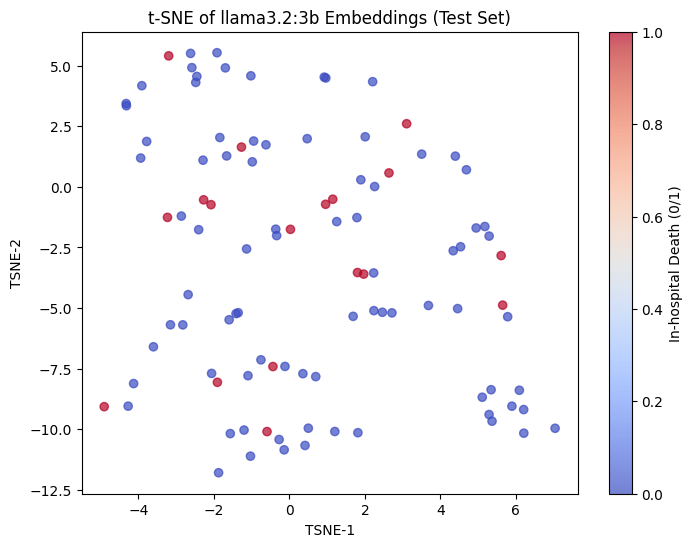

In [17]:
if run_efficient:
    train_X, train_y = build_embeddings(summaries_a_small, summary_col="summary_trend", model_name=llm_model)
    test_X, test_y = build_embeddings(summaries_c_small, summary_col="summary_trend", model_name=llm_model)
else: 
    train_X, train_y = build_embeddings(summaries_a, summary_col="summary_trend", model_name=llm_model)
    test_X, test_y = build_embeddings(summaries_c, summary_col="summary_trend", model_name=llm_model)

probs, auroc, auprc = train_and_evaluate(train_X, train_y, test_X, test_y)
print(f"Test AuROC: {auroc:.4f}, Test AuPRC: {auprc:.4f}")


if run_efficient:
    visualize_tsne(train_X, train_y, title=f"t-SNE of {llm_model} Embeddings (Test Set)")
else: 
    visualize_tsne(test_X, test_y, title=f"t-SNE of {llm_model} Embeddings (Test Set)")


# Q4.3 Using time-series foundation models

Generate small datasets for testing

In [18]:
np.random.seed(1)

a_ids_small = np.random.choice(df_a['RecordID'].unique(), size=100, replace=False)
df_a_small = df_a[df_a['RecordID'].isin(a_ids_small)]

c_ids_small = np.random.choice(df_c['RecordID'].unique(), size=10, replace=False)
df_c_small = df_c[df_c['RecordID'].isin(b_ids_small)]

In [19]:

import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score

import pandas as pd
import torch
from chronos import ChronosPipeline

pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-small",
    device_map=device_map,
    torch_dtype=torch.float32,
)

def get_univariate_embedding(pipeline, single_var_series):
    """
    Given a single univariate time series (1D array), return its Chronos embedding.
    """
    if not isinstance(single_var_series, torch.Tensor):
        series_tensor = torch.tensor(single_var_series, dtype=torch.float32)
    else:
        series_tensor = single_var_series.float()
    # Chronos supports single 1D tensors directly
    with torch.no_grad():
        embedding, _ = pipeline.embed(series_tensor)
        
    if embedding.ndim == 3: # bc of batch logic it returns embedding as torch.Size([1, 49, 512]) 
        embedding = embedding.squeeze(0)
    return embedding.mean(dim=0) # Average pooling

def compute_patient_embedding_naive(pipeline, multivar_data, variables):
    """
    Given a dictionary of { variable_name: 1D time series } for a patient,
    compute the average embedding across variables.
    """
    embeddings = []

    for var_name, series in multivar_data.items():
        if var_name in variables:
            if len(series) == 0:
                continue
            emb = get_univariate_embedding(pipeline, series)
            embeddings.append(emb)

    if not embeddings:
        return torch.zeros(512)  # or whatever the embedding dim is

    return torch.stack(embeddings, dim=0).mean(dim=0)  # shape: [embedding_dim]

def build_patient_embeddings_naive(pipeline, df_timeseries, df_labels, variables):
    """
    Builds Chronos embeddings per patient using naive variable-wise averaging.

    Args:
        pipeline: ChronosPipeline instance
        df_timeseries: long-form time series DataFrame with columns:
                       ['RecordID', 'Time', var1, var2, ...]
        df_labels: DataFrame with columns ['RecordID', 'In-hospital_death']
        variables: list of variable names to embed (e.g., ['HeartRate', 'WBC'])

    Returns:
        X: numpy array of shape [num_patients, embedding_dim]
        y: numpy array of shape [num_patients]
    """
    X_list = []
    y_list = []

    for rid, group in df_timeseries.groupby("RecordID"):
        patient_data = {}

        for var in variables:
            if var in group.columns:
                series = group[var].dropna().values
                if len(series) > 0:
                    patient_data[var] = series

        if not patient_data:
            continue  # skip if no valid data

        emb = compute_patient_embedding_naive(pipeline, patient_data, variables)
        X_list.append(emb.cpu().numpy())

        # Lookup label
        label_row = df_labels[df_labels['RecordID'] == rid]
        if not label_row.empty:
            y_list.append(label_row['In-hospital_death'].values[0])
        else:
            continue  # skip if label missing

    return np.vstack(X_list), np.array(y_list)


# 1) Single Embedding + Linear Probe
list_of_variables = ['Gender', 'Height', 'Weight', 'Age', 'Albumin',
       'Cholesterol', 'DiasABP', 'HCO3', 'HCT', 'HR', 'Mg', 'MAP', 'Na',
       'NIDiasABP', 'NIMAP', 'NISysABP', 'SysABP', 'PaCO2', 'PaO2',
       'Platelets', 'RespRate', 'Temp', 'ALP', 'ALT', 'AST', 'BUN',
       'Bilirubin', 'Creatinine', 'FiO2', 'GCS', 'Glucose', 'K', 'Lactate',
       'MechVent', 'Urine', 'WBC', 'pH', 'SaO2', 'TroponinT', 'TroponinI']

In [20]:
if run_efficient:
    train_X, train_y = build_patient_embeddings_naive(pipeline, df_a_small, death_a,list_of_variables)
    test_X, test_y = build_patient_embeddings_naive(pipeline, df_c_small, death_c, list_of_variables)
else: 
    train_X, train_y = build_patient_embeddings_naive(pipeline, df_a, death_a,list_of_variables)
    test_X, test_y = build_patient_embeddings_naive(pipeline, df_c, death_c, list_of_variables)

clf = LogisticRegression(max_iter=2000)
clf.fit(train_X, train_y)
probs = clf.predict_proba(test_X)[:,1]
auroc = roc_auc_score(test_y, probs)
auprc = average_precision_score(test_y, probs)
print(f"[Naive Aggregation] AuROC={auroc:.4f}, AuPRC={auprc:.4f}")

[Naive Aggregation] AuROC=0.0000, AuPRC=0.1000


Test the embedding function

In [21]:
first_id = df_a['RecordID'].unique()[0]
patient_df = df_a[df_a['RecordID'] == first_id]
multivar_data = {
    var: patient_df[var].dropna().values
    for var in list_of_variables
    if var in patient_df.columns
}

embedding = compute_patient_embedding_naive(pipeline, multivar_data, list_of_variables)
embedding

tensor([-9.2245e-04, -1.0602e-02, -1.5629e-02, -5.4373e-05, -1.6087e-03,
         9.2739e-03, -6.1134e-03, -1.5239e-04,  3.7206e-03,  3.7997e-02,
         2.5337e-03,  3.8007e-03,  8.9798e-03,  2.0604e-02, -3.6300e-03,
         2.1879e-02,  1.4480e-02, -1.1171e-03, -4.1100e-03, -4.4713e-03,
        -7.6508e-03,  4.6493e-03,  1.0959e-02,  3.3737e-05,  7.1037e-03,
        -3.4699e-03,  9.7699e-03, -6.5106e-03, -7.9294e-03,  5.2751e-03,
         9.0876e-04,  1.2864e-02,  1.5575e-02, -4.5882e-04, -5.0590e-03,
         1.6126e-03,  3.2364e-03, -7.3015e-03,  5.5949e-03, -3.4516e-03,
         4.7638e-03, -2.5523e-03,  2.6031e-02, -1.3276e-02, -2.3209e-03,
         5.5624e-04,  1.3505e-02,  6.3859e-03, -1.4276e-03, -2.9440e-03,
         3.6204e-03, -1.1653e-02,  1.0123e-02, -4.9956e-04, -7.2400e-03,
         5.1966e-03, -1.7357e-02, -1.7870e-02,  6.2844e-03, -2.7136e-04,
         1.2787e-02, -5.1073e-03,  7.1918e-03,  1.9930e-02, -1.9038e-03,
         7.7796e-03,  7.7797e-03,  3.6274e-03, -5.9

Making a smarter aggregation: 
Instead of simply averaging embeddings across variables, we can:

Compute an embedding for each variable.

Feed all variable embeddings into a small MLP that outputs a patient-level embedding.

Then, either attach a logistic head for classification or just produce a final embedding for a standard logistic regression.

In [22]:

########################################
# 2) Simple Neural Aggregator Approach #
########################################

class ChannelAggregator(nn.Module):
    def __init__(self,num_vars, embed_dim=512, hidden_dim=64, out_dim=1):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Flatten(),
            nn.Linear(embed_dim * num_vars, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim)
        )
    
    def forward(self, x):
        return self.mlp(x)

def build_multivar_embeddings(pipeline, patient_df, variables):
    """
    Takes a single patient’s time series (dataframe) and computes a stacked tensor of embeddings.
    Returns: torch.Tensor of shape [num_vars, embed_dim]
    """
    embeddings = []
    for var in variables:
        if var in patient_df.columns:
            series = patient_df[var].dropna().values
            if len(series) == 0:
                continue
            with torch.no_grad():
                emb, _ = pipeline.embed(torch.tensor(series, dtype=torch.float32))
                if emb.ndim == 3:
                    emb = emb.squeeze(0)
                emb = emb.mean(dim=0)  # [D]
                embeddings.append(emb.unsqueeze(0))  # [1, D]

    if not embeddings:
        return torch.zeros((1, 512))  # fallback for no valid data
    return torch.cat(embeddings, dim=0)  # [num_vars, D]


def train_aggregator_from_raw(pipeline, aggregator, df_timeseries, df_labels, variables, epochs=5, lr=1e-3, device='cpu'):
    aggregator.to(device)
    optimizer = torch.optim.Adam(aggregator.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss()

    X_list, y_list = [], []
    for rid, group in df_timeseries.groupby("RecordID"):
        emb_stack = build_multivar_embeddings(pipeline, group, variables)
        if emb_stack.shape[0] < 1:
            continue  # skip patients with no valid data

        label_row = df_labels[df_labels["RecordID"] == rid]
        if label_row.empty:
            continue
        label = label_row["In-hospital_death"].values[0]

        X_list.append(emb_stack.unsqueeze(0))  # [1, num_vars, D]
        y_list.append(label)

    X_tensor = torch.cat(X_list, dim=0).float().to(device)  # [batch, num_vars, D]
    y_tensor = torch.tensor(y_list, dtype=torch.float32).unsqueeze(-1).to(device)  # [batch, 1]

    for epoch in range(epochs):
        aggregator.train()
        optimizer.zero_grad()
        logits = aggregator(X_tensor)
        loss = criterion(logits, y_tensor)
        loss.backward()
        optimizer.step()
        print(f"Epoch {epoch+1}/{epochs}, Loss={loss.item():.4f}")

    return aggregator


def evaluate_aggregator_from_raw(pipeline, aggregator, df_timeseries, df_labels, variables, device='cpu'):
    aggregator.eval()
    all_logits = []
    all_labels = []

    with torch.no_grad():
        for rid, group in df_timeseries.groupby("RecordID"):
            emb_stack = build_multivar_embeddings(pipeline, group, variables)
            if emb_stack.shape[0] < 1:
                continue

            label_row = df_labels[df_labels["RecordID"] == rid]
            if label_row.empty:
                continue
            label = label_row["In-hospital_death"].values[0]

            logit = aggregator(emb_stack.unsqueeze(0).to(device))  # [1, 1]
            all_logits.append(logit.item())
            all_labels.append(label)

    all_logits = np.array(all_logits)
    all_labels = np.array(all_labels)
    probs = 1 / (1 + np.exp(-all_logits))

    auroc = roc_auc_score(all_labels, probs)
    auprc = average_precision_score(all_labels, probs)
    return auroc, auprc

In [23]:
# Create model
aggregator = ChannelAggregator(num_vars=len(list_of_variables) , embed_dim=512, hidden_dim=64, out_dim=1)

# Train
aggregator = train_aggregator_from_raw(
    pipeline=pipeline,
    aggregator=aggregator,
    df_timeseries=df_a_small if run_efficient else df_a,
    df_labels=death_a,
    variables=list_of_variables,
    epochs=5,
    lr=1e-3,
    device=device_map
)

# Evaluate
auroc, auprc = evaluate_aggregator_from_raw(
    pipeline=pipeline,
    aggregator=aggregator,
    df_timeseries=df_c_small if run_efficient else df_c,
    df_labels=death_c,
    variables=list_of_variables,
    device=device_map
)

print(f"[Neural Aggregator] AuROC={auroc:.4f}, AuPRC={auprc:.4f}")


Epoch 1/5, Loss=0.6888
Epoch 2/5, Loss=0.5883
Epoch 3/5, Loss=0.5200
Epoch 4/5, Loss=0.4803
Epoch 5/5, Loss=0.4657
[Neural Aggregator] AuROC=0.3333, AuPRC=0.1429
